In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [5]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [6]:
def is_lockdown(date_to_check):
    
    lockdown_intervals = [
    (pd.Timestamp('2020-03-17 00:00:00'), pd.Timestamp('2020-05-10 00:00:00')),  # First lockdown period
    (pd.Timestamp('2020-10-17 00:00:00'), pd.Timestamp('2020-12-14 00:00:00')), # Second lockdown period
    (pd.Timestamp('2021-02-26 00:00:00'), pd.Timestamp('2021-05-02 00:00:00')) # Third lockdown period
    ]        
    for start, end in lockdown_intervals:
        if start <= date_to_check <= end:
            return 1
    return 0

In [47]:
import holidays
def is_fr_bank_holiday(date):
    if date in holidays.France():
        return 1
    else:
        return 0

In [ ]:
import holidays
def counter_age(date, date_of_instalatio):
    if date in holidays.France():
        return 1
    else:
        return 0

In [13]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour
    X['holiday'] = X['date'].apply(is_fr_bank_holiday)
    X['lockdown'] = X['date'].apply(is_lockdown)
    
    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [61]:
data['counter_age_days'] = data['date'] - data['counter_installation_date']
data['counter_age_days'] = data['counter_age_days'].dt.days

<Axes: xlabel='counter_installation_date', ylabel='bike_count'>

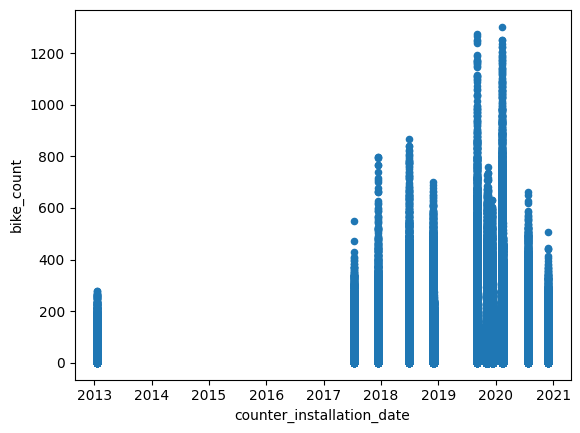

In [65]:
data.plot(kind='scatter', x='counter_installation_date', y='bike_count')

In [36]:
import utils

X, y = utils.get_train_data()
X.head(2)

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
400125,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233
408305,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233


In [37]:
X_dates_encoding = _encode_dates(X[["date"]])
X = pd.concat([X, X_dates_encoding], axis=1) 

In [66]:
X['counter_age_days'] = X['date'] - X['counter_installation_date']
X['counter_age_days'] = X['counter_age_days'].dt.days

In [67]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [68]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

date_cols = ["year", "month", 'day', 'weekday', 'hour', 'holiday', 'lockdown']
scaling_columns = ['counter_age_days']
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ('standard-scaler', StandardScaler(), scaling_columns)
    ]
)

regressor = Ridge()

pipe = make_pipeline(preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour', 'holiday',
                                                   'lockdown']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['counter_age_days'])])),
                ('ridge', Ridge())])

In [82]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.80
Valid set, RMSE=0.75


In [83]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


In [84]:
mask = (
    (X_valid["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_valid["date"] > pd.to_datetime("2021/09/01"))
    & (X_valid["date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = np.exp(y_valid[mask.values]) - 1
df_viz["bike_count (predicted)"] = np.exp(pipe.predict(X_valid[mask])) - 1

Text(0, 0.5, 'bike_count')

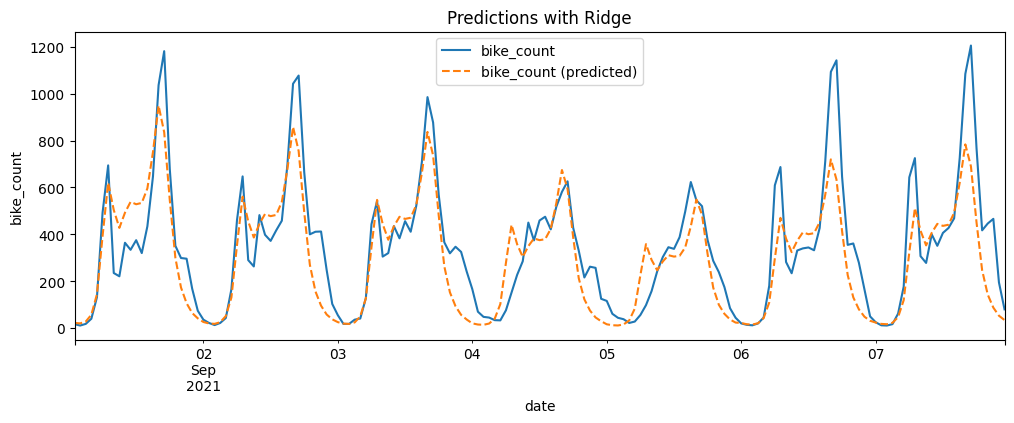

In [85]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge")
ax.set_ylabel("bike_count")

In [91]:
test_data = pd.read_parquet(Path("data") / "final_test.parquet")
test_data.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429


In [92]:
test_dates_encoding = _encode_dates(test_data[["date"]])
test_data = pd.concat([test_data, test_dates_encoding], axis=1) 

In [94]:
test_data['counter_age_days'] = test_data['date'] - test_data['counter_installation_date']
test_data['counter_age_days'] = test_data['counter_age_days'].dt.days

In [96]:
y_pred = pipe.predict(test_data)
results = pd.DataFrame(
    dict(
        Id=np.arange(y_pred.shape[0]),
        log_bike_count=y_pred,
    )
)
results.to_csv("submission.csv", index=False)